# Computing a threshold

In this tutorial, we will present different ways to compute the threshold of the 2D toric code using PanQEC. The first method consists in explicitly writing a loop over physical error rates and system sizes, and calculating the failure rates for each parameter. The second method is more powerful and uses PanQEC's higher-level functions. It outputs a result dataframe from which the error bars, the threshold, the subthreshold scaling factor, and other metrics can be computed automatically.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
import IPython

## Method 1: step-by-step

In [7]:
from panqec.codes import Toric2DCode
from panqec.error_models import PauliErrorModel
from panqec.decoders import Toric2DMatchingDecoder

We start by initializing all the models needed in our simulation

In [3]:
sizes = [4, 6, 8]
error_rates = np.linspace(0.1, 0.2, 20)

codes = [Toric2DCode(L) for L in sizes]
error_model = PauliErrorModel(1/3, 1/3, 1/3)
decoders = [[Toric2DMatchingDecoder(code, error_model, p) 
             for p in error_rates] for code in codes]

We can now run our main loop to estimate the logical error rate for all the sizes and physical error rates. 

In [4]:
def plot_threshold(logical_error_rates, i_run, n_runs):
    """Plot routine on loop."""

    plt.clf()
    for i_size in range(len(sizes)):
        plt.plot(error_rates, logical_error_rates[i_size], '-o', label=f"L={sizes[i_size]}")
    plt.title(f'Run {i_run + 1} / {n_runs}')
    plt.xlabel('Physical Error Rate', fontsize=20)
    plt.ylabel('Logical Error Rate', fontsize=20)
    plt.legend()
    
    # For updating the plot dynamically in the loop
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())

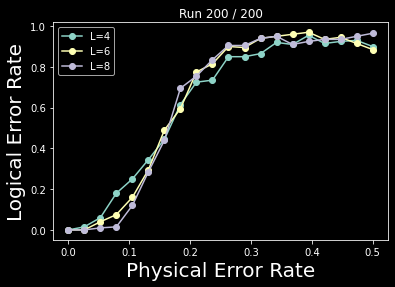

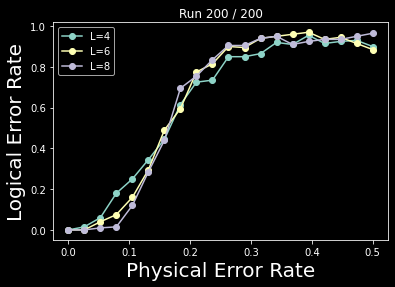

In [6]:
n_runs = 200
plot_every = 5

n_failures = np.zeros((len(sizes), len(error_rates)))

for i_run in range(n_runs):
    for i_size in range(len(sizes)):
        for i_p in range(len(error_rates)):
            error = error_model.generate(codes[i_size], error_rates[i_p])
            syndrome = codes[i_size].measure_syndrome(error)
            correction = decoders[i_size][i_p].decode(syndrome)
            
            residual_error = (error + correction) % 2
            in_codespace = codes[i_size].in_codespace(residual_error)
            is_logical_error = codes[i_size].is_logical_error(residual_error)
            
            failure = is_logical_error or not in_codespace
            
            n_failures[i_size, i_p] += int(failure)
    
    logical_error_rates = n_failures / (i_run + 1)
    
    if (i_run + 1) % plot_every == 0:
        plot_threshold(logical_error_rates, i_run, n_runs)

## Method 2: using an input dictionary

In [11]:
from panqec.analysis import get_results_df_from_batch, get_thresholds_df
from panqec.utils import get_direction_from_bias_ratio
from panqec.plots import threshold_plot

from panqec.simulation import (
    read_input_dict
)
import datetime

from tqdm.notebook import tqdm
import IPython.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Parameters
# Change these as you wish.

input_data = {
    'ranges': {
        'label': 'toric-2d',
        'code': {
            'model': 'Toric2DCode',
            'parameters': [
                {'L_x': 4},
                {'L_x': 6},
                {'L_x': 8},
            ]
        },
        'noise': {
            'model': 'PauliErrorModel',
            'parameters': [
                {'r_x': 0.33, 'r_y': 0.33, 'r_z': 0.34}
            ],
        },
        'decoder': {
            'model': 'BeliefPropagationOSDDecoder',
            'parameters': [{'osd_order': 0}]
        },
        'probability': np.linspace(0, 0.45, 20).tolist()
    }
}

# Frequecy of plot update.
plot_frequency = 10

# Frequency of saving to file.
save_frequency = 1000

# Target number of simulations.
n_trials = 200

In [5]:
batch_sim = read_input_dict(
    input_data,
    update_frequency=plot_frequency,
    save_frequency=save_frequency
)

In [6]:
def update_plot():
    """Plot routine on loop."""
    remaining_time = batch_sim.estimate_remaining_time(n_trials)
    df = pd.DataFrame(batch_sim.get_results())


    plt.clf()
    for code_size in df['size'].unique():
        df_filtered = df[df['size'] == code_size]
        plt.errorbar(
            df_filtered['probability'], df_filtered['p_est'],
            yerr=df_filtered['p_se'],
            label=f'L={code_size[0]}'
        )
    plt.title(f'Time remaining {datetime.timedelta(seconds=int(remaining_time))}')
    plt.xlabel('Physical Error Rate', fontsize=20)
    plt.ylabel('Logical Error Rate', fontsize=20)
    plt.legend()
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())

batch_sim.on_update = update_plot

In [7]:
batch_sim.run(n_trials, progress=tqdm)

0it [00:00, ?it/s]

### Analyzing the results

In [8]:
results_df = get_results_df_from_batch(batch_sim, input_data['ranges']['label'])
results_df.head(10)

,size,code,n,k,d,error_model,probability,n_success,n_fail,n_trials,p_est,p_se,label,noise_direction,p_x,p_x_se,p_z,p_z_se
0,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.000000,1000,0,1000,0.000,0.000000,toric-2d,"(0.33, 0.33, 0.34)",0.000,0.000000,0.000,0.000000
1,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.023684,984,16,1000,0.016,0.003966,toric-2d,"(0.33, 0.33, 0.34)",0.007,0.002635,0.009,0.002985
2,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.047368,952,48,1000,0.048,0.006757,toric-2d,"(0.33, 0.33, 0.34)",0.028,0.005214,0.022,0.004636
3,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.071053,875,125,1000,0.125,0.010453,toric-2d,"(0.33, 0.33, 0.34)",0.068,0.007957,0.067,0.007902
4,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.094737,809,191,1000,0.191,0.012424,toric-2d,"(0.33, 0.33, 0.34)",0.116,0.010121,0.107,0.009770
5,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.118421,700,300,1000,0.300,0.014484,toric-2d,"(0.33, 0.33, 0.34)",0.171,0.011900,0.185,0.012273
6,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.142105,597,403,1000,0.403,0.015503,toric-2d,"(0.33, 0.33, 0.34)",0.248,0.013650,0.248,0.013650
7,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.165789,468,532,1000,0.532,0.015771,toric-2d,"(0.33, 0.33, 0.34)",0.329,0.014851,0.334,0.014907
8,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.189474,405,595,1000,0.595,0.015516,toric-2d,"(0.33, 0.33, 0.34)",0.366,0.015225,0.395,0.015451
9,"(4, 4)",Toric 4x4,32,2,4,Pauli X0.3300Y0.3300Z0.3400,0.213158,288,712,1000,0.712,0.014313,toric-2d,"(0.33, 0.33, 0.34)",0.491,0.015801,0.505,0.015803


In [9]:
thresholds_df, trunc_results_df, params_bs_list = get_thresholds_df(results_df, 
                                                                    ftol_est=1e-4,
                                                                    ftol_std=1e-4,
                                                                    maxfev=10000)
thresholds_df

,error_model,noise_direction,r_x,r_y,r_z,h,v,eta_x,eta_y,eta_z,p_th_sd,p_th_nearest,p_left,p_right,p_th_fss,p_th_fss_left,p_th_fss_right,p_th_fss_se,fss_params
0,Pauli X0.3300Y0.3300Z0.3400,"(0.33, 0.33, 0.34)",0.33,0.33,0.34,0.0,0.008165,0.492537,0.492537,0.515152,0.171,0.165789,0.165,0.19,0.16828,0.166443,0.170969,0.005637,"(0.17763157894736842, 2.5004453713537473, 0.54..."


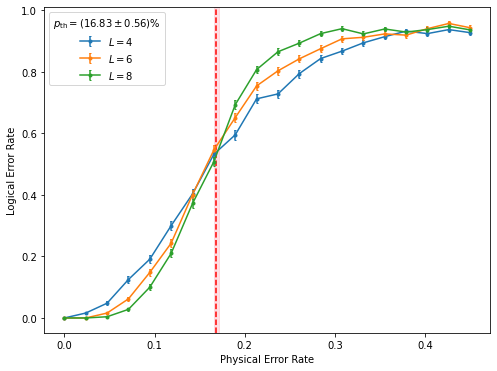

In [19]:
threshold_plot(plt, results_df, thresholds_df, figsize=(8,6))